# __Code Description__

* 1. Load data and handle duplicates, empty values and outlier by removing rows<br>
        Also remove columns(attributes) that is not related with result('id')
* 2. Calculate correlation and draw heatmap correlation<br>
        a. Using heatmap correlation with features (X) - remove columns that have a high correlation(greater than 0.95) with other features<br>
        b. Using heatmap correlation with features (X) and target (y) - remove columns that have a low correlation with target<br>
* 3. Split the dataset into training data and test data (80/20)<br>
* 4. Split the training data with N blocks for N fold Validation (in this case, N=5)
* 5. Choose the best K for KNN algorithms using N fold Validation
* 6. Predict the test dataset using the best K and calculate the accuracy

# __Install Libraries__

In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install seaborn

In [40]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sb
import math
import time as t

# __Question 1__

#### Read **Iris Flower** data

* Check duplicate 
* Check missing data 
* Check outliers <br>
    Z score = (X-mean)/std.deviation<br>
    Z score allows us to check whether the data value is greater of less than average and how far it is from the average point.<br>
    <br>
    68% of data points are between +/-1 standard deviation<br>
    95% of data points are between +/-2 standard deviation<br>
    99% of data points are between +/-3 standard deviation<br>
    99.9% of data points are between +/-3 standard deviation<br>

In [41]:
df_iris = pd.read_csv(r'Iris.csv')
df_iris = df_iris.drop(columns=['Id'])
df_iris = df_iris.drop_duplicates(subset=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'], ignore_index=True)
df_iris = df_iris.dropna()
df_iris = df_iris.reset_index(drop=True)
z_score = st.zscore(df_iris.drop(columns=['Species']))

filtered = (np.abs(z_score)< 3).all(axis=1)
df_iris = df_iris[filtered].reset_index(drop=True)
#print(df_iris)

#### Put all attributes on the same scale

In [42]:
iris_X = df_iris.drop(columns=['Species'])
iris_Y = df_iris['Species']
scaler = StandardScaler()
scaler.fit(iris_X)
#print(scaler.mean_)
iris_X = scaler.transform(iris_X)
#print(iris_X)

#### Split Tarin(70)/Test(20)

In [43]:
iris_train_X, iris_test_X, iris_train_Y, iris_test_Y = train_test_split(iris_X, iris_Y, test_size=0.2, train_size=0.7, random_state=42)

#### Best K (between K=1 to K=6)

In [44]:
accuracy = []
for i in range(1,7):
    neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i)
    neigh.fit(iris_train_X, iris_train_Y)
    correct = 0
    for test in range(len(iris_test_X)):
        result = neigh.predict(iris_test_X[test:test+1])
        if result == iris_test_Y[test:test+1].item():
            correct += 1
        
    accuracy.append(correct/len(iris_test_X))

print(accuracy)
max_index = np.argmax(accuracy)
best_k = max_index + 1
print('Best K is',best_k)

[0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9666666666666667, 0.9666666666666667, 1.0]
Best K is 6


#### Plot the relationship between different K values and accruacy

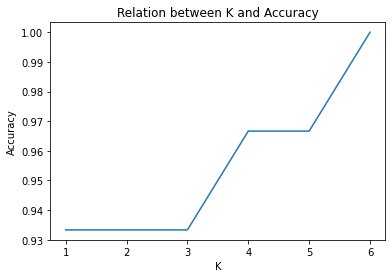

In [7]:
p = plt.plot([1,2,3,4,5,6], accuracy)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Relation between K and Accuracy')

mp.pyplot.show()

#### Evaluate model using best K

In [8]:
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(iris_train_X, iris_train_Y)
correct = 0
for test in range(len(iris_test_X)):
    result = neigh.predict(iris_test_X[test:test+1])
    if result == iris_test_Y[test:test+1].item():
        correct += 1
            
print('accuracy =', correct/len(iris_test_X))

accuracy = 1.0


# __Question 2__

### Implement KNN algorithm

In [45]:
def MostFrequent(targets):
    elements, num = np.unique(targets, return_counts = True)
    max_index = np.argmax(num)
    return elements[max_index]

In [46]:
def Distances(train_X, test_X):
    train_test_sub = train_X.sub(test_X)
    train_test_sq = train_test_sub.mul(train_test_sub)
    df_distances = pd.DataFrame(data={'distance':train_test_sq.sum(axis=1)}, index=train_X.index)
    return df_distances

In [47]:
def KNN(train_X, train_Y, test_X, K, weighted=False):
    
    distances = Distances(train_X,  test_X)
    distances_k = distances.sort_values(by='distance')[:K]
    indices = distances.sort_values(by='distance')[:K].index
    if weighted == False:
        targets = [train_Y[index] for index in distances_k.index]
        result = MostFrequent(targets)
    elif weighted == True:
        distances_k = 1/distances_k
        target_value = np.unique(train_Y)
        targets = []
        for val in target_value:
            filtered = [train_Y[index]==val for index in distances_k.index]
            weight_sum = distances_k[filtered].sum(axis=0)['distance']
            targets.append(weight_sum)
        result = target_value[np.argmax(targets)]
        
    return result

## Data Exploration

### Organize the data

#### 1. Read __Wisconsin Breast Cancer__ data using same way above

In [48]:
df = pd.read_csv(r'Breast_Cancer.csv')
print('Original:',len(df))
df = df.drop(columns=['id'])

df = df.dropna()
print('missing values:',len(df))

df = df.drop_duplicates(ignore_index=True)
print('duplicates:',len(df))

df = df.reset_index(drop=True)
z_score = st.zscore(df.drop(columns=['diagnosis']))
filtered = (np.abs(z_score)< 4).all(axis=1)
df = df[filtered].reset_index(drop=True)
print('Outliers:',len(df))

Original: 569
missing values: 569
duplicates: 569
Outliers: 535


#### 2. Normalize using the formula 
 * ai'= (ai - min(a))/(max(a)-min(a) 

In [49]:
def Normalize(data):
    result = pd.DataFrame({})
    for col in data.columns:
        max_value = data[col].max()
        min_value = data[col].min()
        normalized = (data[col]-min_value)/(max_value-min_value)
        result[col] = normalized
    return result

In [50]:
normalized = Normalize(df.drop(columns=['diagnosis']))
#print(normalized)

### Correlations between attributes

In [51]:
def correlation(df, target_name):
    drop=[]
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.columns[j] == target_name and corr_matrix.columns[i] != target_name:
                if (np.abs(corr_matrix.iloc[i,j]) < 0.05) and (corr_matrix.columns[j] not in drop):
                          print(corr_matrix.columns[i], 'has LOW CORRELATION with TARGET')
                          drop.append(corr_matrix.columns[i])
            
            if (np.abs(corr_matrix.iloc[i,j]) > 0.95) and (corr_matrix.columns[j] not in drop):
                print(corr_matrix.columns[i], '&', corr_matrix.columns[j], 'have HIGH CORRELATION')
                drop.append(corr_matrix.columns[i])
                
    return drop

Label the target values(M,B) for plotting scatter matrix

In [53]:
labels, uniques = pd.factorize(df['diagnosis'])
df['diagnosis'] = labels

#### 1. Plot Heatmap

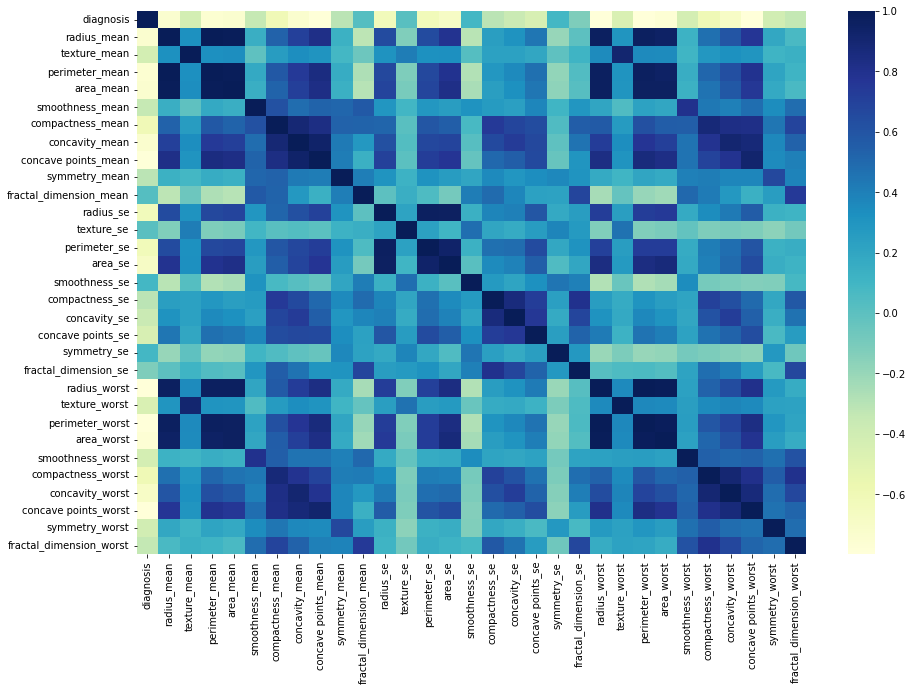

perimeter_mean & radius_mean have HIGH CORRELATION
area_mean & radius_mean have HIGH CORRELATION
fractal_dimension_mean has LOW CORRELATION with TARGET
texture_se has LOW CORRELATION with TARGET
perimeter_se & radius_se have HIGH CORRELATION
area_se & radius_se have HIGH CORRELATION
radius_worst & radius_mean have HIGH CORRELATION
perimeter_worst & radius_mean have HIGH CORRELATION
['perimeter_mean', 'area_mean', 'fractal_dimension_mean', 'texture_se', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst']


In [54]:
mp.pyplot.figure(figsize=(15,10))
dataplot_feature = sb.heatmap(df.corr(), cmap="YlGnBu")
mp.pyplot.show()
to_drop = correlation(df, 'diagnosis')
print(to_drop)

df = df.drop(columns=to_drop)

#### About above plot

* __High__ correlation between features<br>
        radius_mean : perimeter_mean, area_mean, radius_worst, perimeter_worst
        radius_se : perimeter_se, area_se
* __Low__ correlation with __target__ values<br>
        fractal_dimension_mean, texture_se
        

#### 2. Scatter Matrix

diagnosis 0= M
diagnosis 1= B


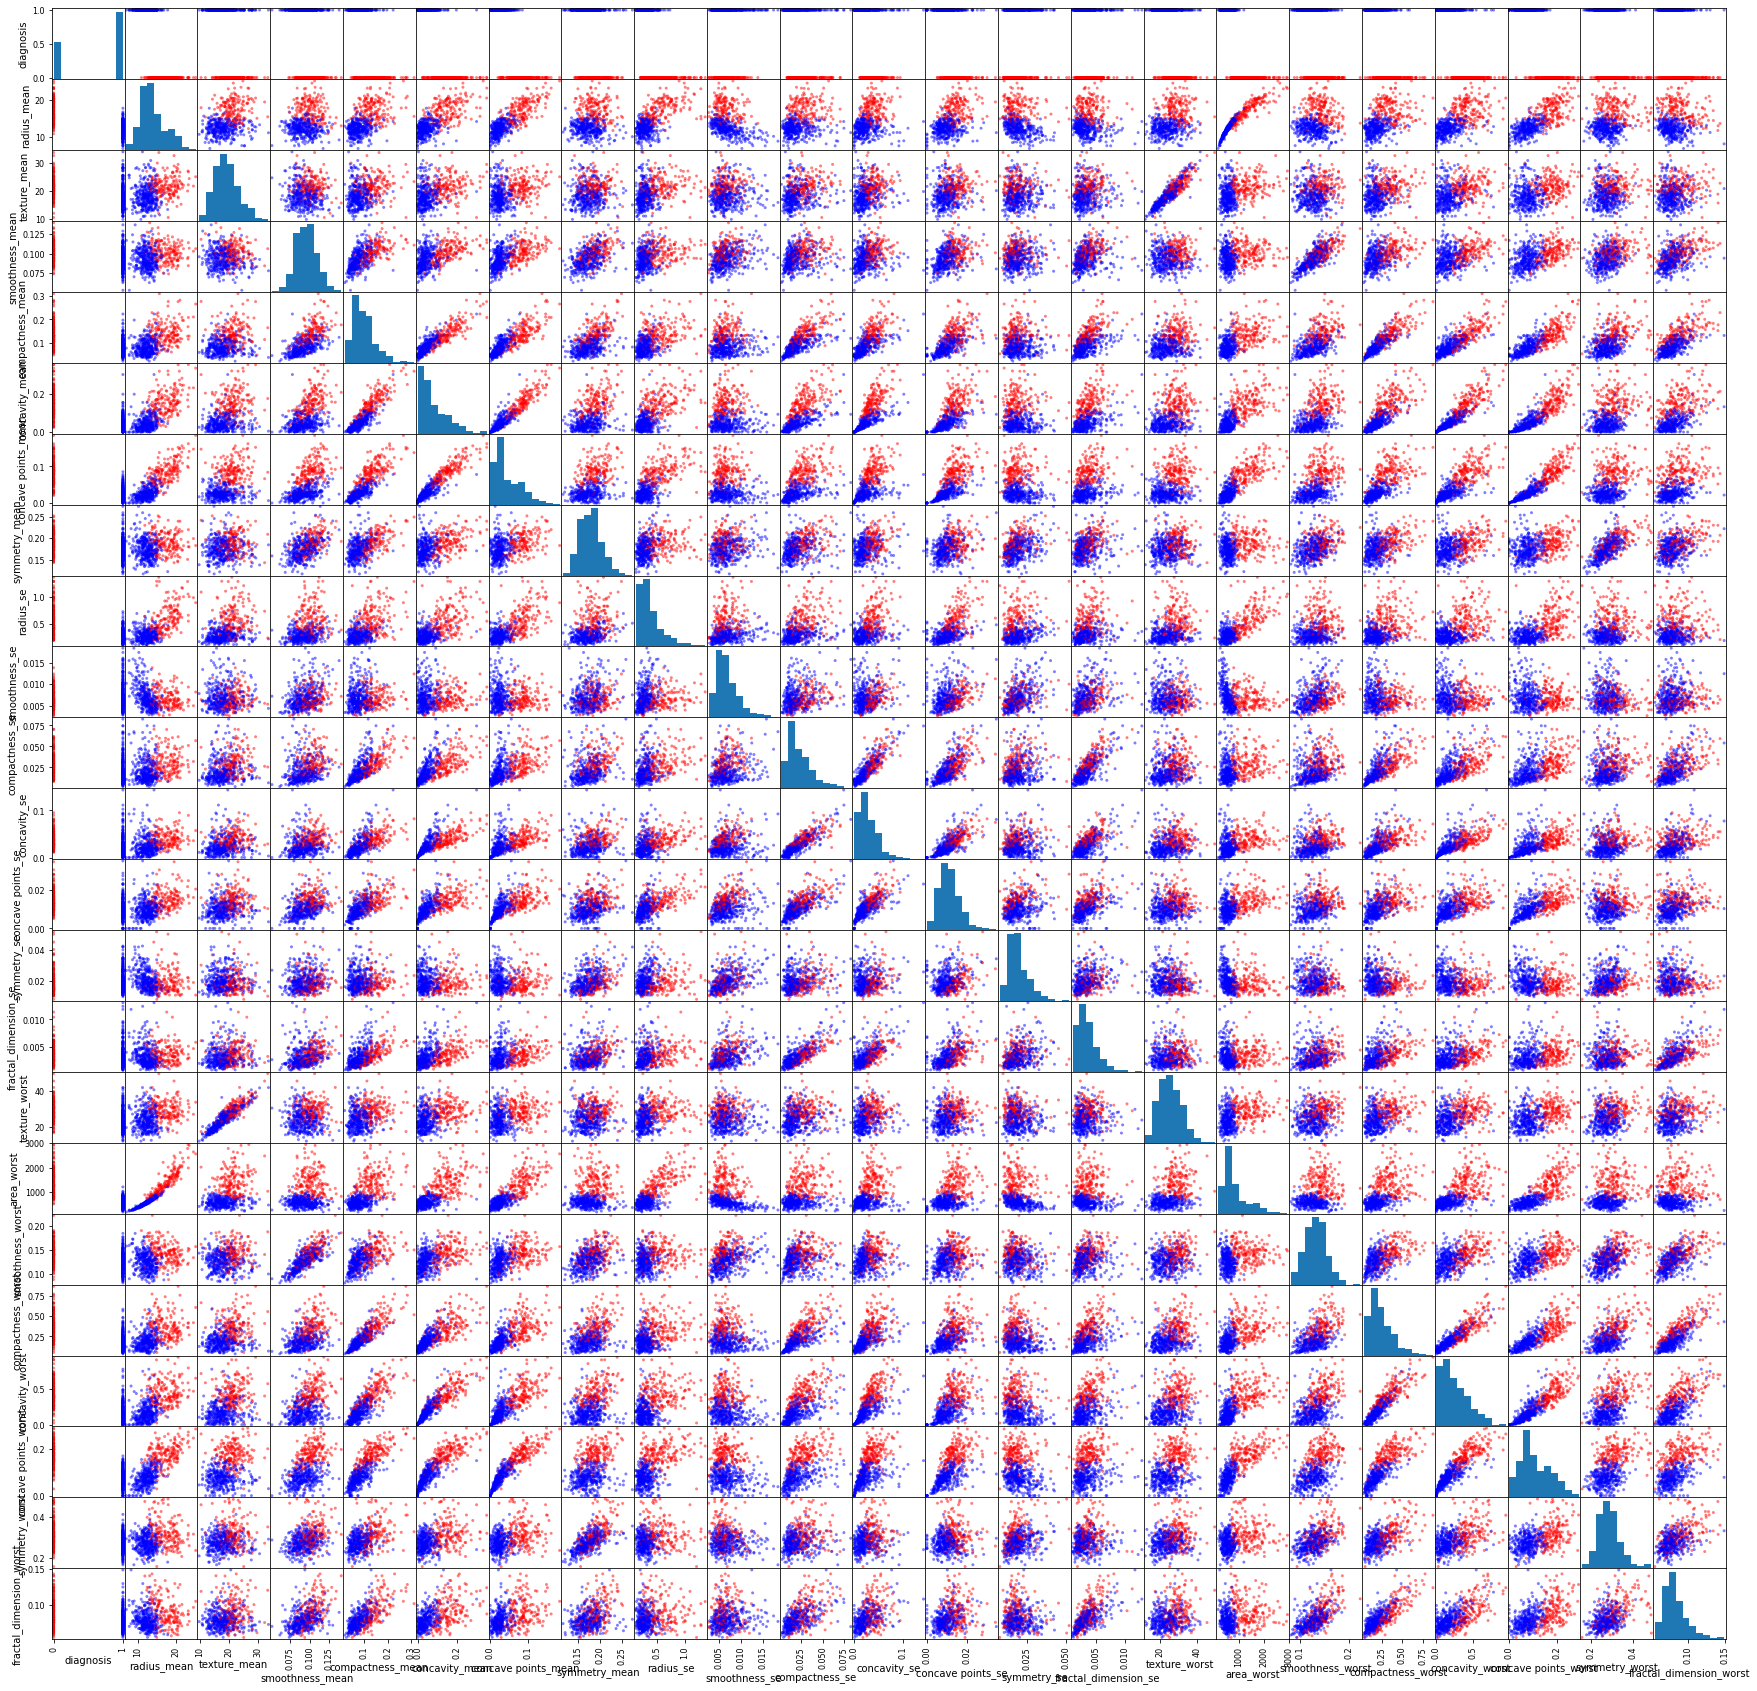

In [18]:
color_wheel = {1: 'red', 
               2: 'blue'}
colors_mapped = df['diagnosis'].map(lambda x: color_wheel.get(x+1))

print('diagnosis 0=', uniques[0])
print('diagnosis 1=', uniques[1])

pd.plotting.scatter_matrix(df, color=colors_mapped,figsize=(30,30))
mp.pyplot.show()

#### About above scatter matrix plot

* From the graph above, we can see that the __samller__ the value of most attributes, the greater the probability of getting the result of __'Benign'__(blue color)

In [19]:
#Before KNN algorithm, revert the target columns [0,1] -> [M, B]
df['diagnosis'] = uniques[labels]

### Split  __Wisconsin Breast Cancer__ data (80/20 - training/test)

In [20]:
df_training, df_test = train_test_split(df, test_size=0.2, train_size=0.8, random_state=42)

print(len(df_training))
print(len(df_test))

428
107


## Tune the number of nearest neighbors K

In [21]:
def NFoldCrossValidationSplit(df,N):
    #divide into N blocks
    data_blocks = []
    df_copy = df
    fraction = 1.0/N
    for i in range(N):
        fraction = 1.0/(N-i)
        if fraction == 1.0:
            df_selected = df_copy
        else:
            df_copy, df_selected = train_test_split(df_copy, test_size=fraction, random_state=42)
            #df_selected = df_copy.sample(frac = fraction)
            #df_copy = df_copy.drop(df_selected.index)
        data_blocks.append(df_selected.index)
    return data_blocks

In [22]:
def NFoldCrossValidation(df,data_blocks,N,target_name):

    #split - attributes & target
    df_att = df.drop(columns=target_name)
    df_target = df[target_name]
    
    accuracy_k = np.zeros((math.ceil(len(df)*(N-1.0)/N)))
    for block in data_blocks:
        #split into train & test data
        test_X = df_att.loc[block]
        test_Y = df_target.loc[block]
        
        train_X = df_att.drop(block)
        train_Y = df_target.drop(block)
        
        correct = np.zeros((len(train_X)))
        
        #predict
        for test_index in test_X.index:
            distances = Distances(train_X, test_X.loc[test_index]).sort_values(by='distance')
            targets = []
            
            #store the number of correct prediction for each k
            for k in range(len(train_X)):
                index_train = distances[k:k+1].index[0]
                targets.append(train_Y[index_train])
                result = MostFrequent(targets)
                if result == test_Y[test_index]:
                    correct[k] += 1

            correct = correct/len(test_X)
                          
            for i in range(len(train_X)):
                accuracy_k[i] += correct[i]
                     
    for k in range(len(accuracy_k)):
        accuracy_k[k] = accuracy_k[k]/N
                          
    max_index = np.argmax(accuracy_k)
    return list(accuracy_k), max_index+1

#### Split data into N folds

In [23]:
data_blocks = NFoldCrossValidationSplit(df_training,5)

#### Calculate the best K with N folds

In [55]:
accuracies, k = NFoldCrossValidation(df_training,data_blocks,5,'diagnosis')
print('Accuracy of [ K =',k,']:',accuracies[k])

Accuracy of [ K = 56 ]: 0.933669138061067


#### Graph [ K value vs Accuracy ]

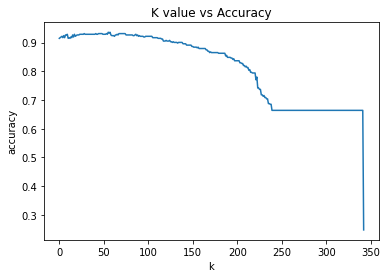

K= 56 is the best value


In [25]:
mp.pyplot.plot(accuracies)
mp.pyplot.xlabel('k')
mp.pyplot.ylabel('accuracy')
mp.pyplot.title('K value vs Accuracy')

mp.pyplot.show()

print('K=',k,'is the best value')

#### Predict and calculate accuracy with chosen K

In [26]:
def Predict(train, test, target_name, k, weighted = False):
    train_X = train.drop(columns=[target_name])
    train_Y = train[target_name]
    
    test_X = test.drop(columns=[target_name])
    test_Y = test[target_name]
    
    accuracy = 0
    for row in test_X.index:
        predicted = KNN(train_X, train_Y, test_X.loc[row], k, weighted)
        if predicted == test_Y[row]:
            accuracy += 1
    
    accuracy = accuracy/len(test_X)
    return accuracy

In [27]:
accuracy = Predict(df_training, df_test, 'diagnosis', k)
print('Accuracy for k',k,'=',accuracy*100.0,'%')

Accuracy for k 56 = 93.45794392523365 %


### Evaluation Matrices

In [56]:
Ks = []
accuracy_by_Ks=[]

K_val = 10
while K_val < 100:
    Ks.append(K_val)
    accuracy_by_Ks.append(Predict(df_training, df_test, 'diagnosis', K_val))
    K_val += 5
df_accuracy_by_Ks = pd.DataFrame({'accuracy' : accuracy_by_Ks}, index=Ks)
print(df_accuracy_by_Ks)

    accuracy
10  0.934579
15  0.934579
20  0.915888
25  0.934579
30  0.915888
35  0.925234
40  0.934579
45  0.934579
50  0.934579
55  0.934579
60  0.934579
65  0.943925
70  0.943925
75  0.934579
80  0.925234
85  0.943925
90  0.934579
95  0.934579


### Try the section that has highest accuracy 

In [29]:
Ks = []
accuracy2_by_Ks=[]

highest_k = df_accuracy_by_Ks.iloc[np.argmax(accuracy_by_Ks)].name
print('Highest K:', highest_k)
K_val = highest_k - 4
while K_val < highest_k + 4:
    Ks.append(K_val)
    accuracy2_by_Ks.append(Predict(df_training, df_test, 'diagnosis', K_val))
    K_val += 1

df_accuracy2_by_Ks = pd.DataFrame({'accuracy' : accuracy2_by_Ks}, index=Ks)
print(df_accuracy2_by_Ks)

Highest K: 65
    accuracy
61  0.943925
62  0.943925
63  0.943925
64  0.943925
65  0.943925
66  0.943925
67  0.943925
68  0.943925


### Choose the best K
* This K has the highest accuracy on test dataset, while K from N fold validation has the highest accuracy on the training set

In [36]:
best_K = df_accuracy2_by_Ks.iloc[np.argmax(df_accuracy2_by_Ks)].name
print('K=',best_K)

print('Accuracy =',Predict(df_training, df_test, 'diagnosis', best_K)*100.0,'%')

K= 61
Accuracy = 94.39252336448598 %


#### Test with weight (with same K)

In [37]:
accuracy = Predict(df_training, df_test, 'diagnosis', best_K, True)
print('Accuracy for k',best_K,'=',accuracy*100.0,'%')

Accuracy for k 61 = 94.39252336448598 %


# Analyze and Explain

* Best K<br>
        For N fold Validation, I divide the dataset randomly. So I could get different results for K every time I run it again.
        But as you can see in above [ K vs Accuracy ] graph, the accuracy starts to drop from the point where the K value is close to 100.
        The shape of this graph has always been similar every time I run it again. Thus, the best K value does not exceed 100 for this dataset.  
        
* KNN Algorithm with weight
        According to the result of running it many times with differently split data every time, it increases the accuracy about [0-3]% 
        

* Overfitting in data set
        Before removing some columns using correlations, this data set had lots of columns(attributes) to consider. It can also cause overfitting.
        
       

### Amount of training data vs Performance

In [38]:
i = 5
number_training = []
accuracy_data = []
times = []
while i < len(df_training):
    start = t.time()
    accuracy = Predict(df_training[:i], df_test, 'diagnosis', best_K)
    times.append(t.time()-start)
    accuracy_data.append(accuracy)
    number_training.append(i)
    i += 5

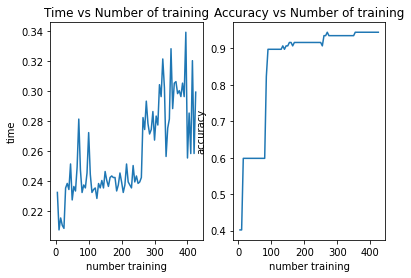

In [39]:
fig = mp.pyplot.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(number_training, times, label='time - number training')
ax2.plot(number_training, accuracy_data, label='accuracy - number training')
ax1.set_xlabel('number training')
ax1.set_ylabel('time')
ax1.set_title('Time vs Number of training')
ax2.set_xlabel('number training')
ax2.set_ylabel('accuracy')
ax2.set_title('Accuracy vs Number of training')

mp.pyplot.show()

#### About above graphs
* Time vs Number of training data
        The graph is jagged, but as the number of data increases, the overall time increases.
* Accuracy vs Number of training data
        Overall, the greater the number of data, the greater the accuracy. However, it seems to be similar after a certain point.